<div class="alert alert-block alert-info">
<strong>Name and surname:


**Neil de la Fuente**</strong>
</div>

## Part 3. Self-training

Self-training methods (sometimes also called _self-learning_ methods) are the most basic of pseudo-labelling approaches. They consist of a **single supervised classifier** that is iteratively trained on both **labelled** data and data that has been **pseudo-labelled** in previous iterations of the algorithm.

Self-training procedure:
- At the beginning of the self-training procedure, **a supervised classifier is trained on only the labelled data**.
- The resulting classifier is used to **obtain predictions for the unlabelled data points**.
- Then, the most confident of these predictions are added to the labelled data set.
- Next, **the supervised classifier is re-trained** on both the original labelled data and the newly obtained pseudo-labelled data.
- This procedure is typically **iterated until no more unlabelled** data remain.

<u>Questions</u> (**3 points**):
1. Implement (manually) a function to apply the _self-training_ algorithm, as previously stated.
- Use the same CNN from the aforementioned exercises.
- For each iteration, you must provide (at least) the following information:
  - The number of items added to the labelled data
  - The number of correctly / incorrectly classified items that are added to the labelled data
2. Regarding the _threshold_ parameter, analyse a range between (60-90) and justify the best value.
3. With the best threshold, report the same evaluation metrics.

**Notes**:
- **DO NOT USE** any third-party implementation, such as `SelfTrainingClassifier` from `sklearn`.

In [53]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import random_split, DataLoader, ConcatDataset, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler

In [54]:
class SemiSupervisedDataset(Dataset):
    def __init__(self, dataset, labeled=True):
        self.dataset = dataset
        self.labeled = labeled
        self.actual_labels = [item[1] for item in self.dataset] if not self.labeled else []

    def __getitem__(self, index):
        data, label = self.dataset[index]
        if self.labeled:
            return data, label
        else:
            return data, -1  # Return -1 for unlabeled data

    def __len__(self):
        return len(self.dataset)

    def get_actual_labels(self):
        return self.actual_labels

In [55]:
# Import FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Print the shapes of the resulting datasets
print(f"Training data shape: {len(train_dataset)}")
print(f"Testing data shape: {len(test_dataset)}")



Training data shape: 60000
Testing data shape: 10000


In [56]:


DL_size = 10000
DU_size = len(train_dataset) - DL_size

DL_dataset, DU_dataset = random_split(train_dataset, [DL_size, DU_size])

#Pass them through our Semisupervised dataset in order to erase labels
DL_dataset = SemiSupervisedDataset(DL_dataset, labeled=True)
DU_dataset = SemiSupervisedDataset(DU_dataset, labeled=False)

DL_loader = DataLoader(DL_dataset, batch_size=100, shuffle=True)
DU_loader = DataLoader(DU_dataset, batch_size=100, shuffle=True)

print(f"DL data shape: {len(DL_dataset)}")
print(f"DU data shape: {len(DU_dataset)}")
print(f"Testing data shape: {len(test_dataset)}")

DL data shape: 10000
DU data shape: 50000
Testing data shape: 10000


In [57]:
class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNN, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(5,5)) #[batch_size, n_channels, 24, 24] (28 - 5 + 1 = 24)
        self.relu = nn.ReLU() #[batch_size, n_channels, 12, 12] (24 / 2 = 12)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))

        # Calculate in_features after flattening
        self.in_features_after_flatten = n_channels * 12 * 12
        self.fc = nn.Linear(in_features=self.in_features_after_flatten, out_features=n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flatten the tensor
        x = x.view(x.size(0), self.in_features_after_flatten)
        x = self.fc(x)
        return x




In [58]:
# @title auxiliary function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [59]:
@torch.no_grad()
def validate(criterion, model, loader):
    val_loss = 0
    model.eval()

    all_preds = []
    all_labels = []

    for data, target in tqdm(loader, desc="Validation", total=len(loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    val_loss /= len(loader)

    return val_loss, np.array(all_preds).flatten(), np.array(all_labels).flatten()



def train(epoch, criterion, model, optimizer, loader):
    total_loss = 0.0
    model.train()

    for batch_idx, (data, target) in tqdm(enumerate(loader), desc=f"Training Epoch {epoch+1}", total=len(loader)):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}')

        total_loss += loss.item()

    return total_loss / len(loader)  # Normalize by number of batches


In [62]:
# Implementation of self-training function
def self_training(epochs, DL_dataset, DU_dataset, model, criterion, optimizer, threshold):
    actual_DU_labels = DU_dataset.get_actual_labels()

    for epoch in range(epochs):
        DL_loader = DataLoader(DL_dataset, batch_size=100, shuffle=True)
        DU_loader = DataLoader(DU_dataset, batch_size=100, shuffle=False)  # Not shuffling for easy indexing

        #Train on the labeled dataset
        train(epoch, criterion, model, optimizer, DL_loader)

        #Make predictions on the unlabeled dataset
        pseudo_labels = []
        confidences = []

        model.eval()
        with torch.no_grad():
            for data, _ in DU_loader:
                data = data.to(device)
                outputs = F.softmax(model(data), dim=1)
                confidence, pseudo_label = torch.max(outputs, dim=1)
                pseudo_labels.extend(pseudo_label.cpu().numpy())
                confidences.extend(confidence.cpu().numpy())

        #Select the most confident predictions and add them to DL_dataset
        threshold = threshold
        high_confidence_idxs = [idx for idx, conf in enumerate(confidences) if conf > threshold]

        #Check how many are correctly labeled
        correct_count = 0
        incorrect_count = 0
        for idx in high_confidence_idxs:
            if pseudo_labels[idx] == actual_DU_labels[idx]:
                correct_count += 1
            else:
                incorrect_count += 1

        print(f"\nEpoch {epoch + 1}: Added {len(high_confidence_idxs)} items to the labeled dataset.")
        print(f"\nCorrectly labeled: {correct_count}, Incorrectly labeled: {incorrect_count}\n\n")

        newly_labeled_data = Subset(DU_dataset.dataset, high_confidence_idxs)
        newly_labeled_data = SemiSupervisedDataset(newly_labeled_data, labeled=True)
        DL_dataset = ConcatDataset([DL_dataset, newly_labeled_data])

        #Remove the most confident samples from DU_dataset
        remaining_idxs = [idx for idx in range(len(DU_dataset)) if idx not in high_confidence_idxs]
        DU_dataset = Subset(DU_dataset.dataset, remaining_idxs)
        DU_dataset = SemiSupervisedDataset(DU_dataset, labeled=False)

        #Remove the most confident samples' actual labels from actual_DU_labels
        actual_DU_labels = [label for idx, label in enumerate(actual_DU_labels) if idx not in high_confidence_idxs]

        #Update the actual labels in DU_dataset
        DU_dataset.actual_labels = actual_DU_labels


Number of parameters: 23466
Training model with threshold: 0.6


Training Epoch 1:   3%|▎         | 3/100 [00:00<00:03, 27.87it/s]

Train Epoch: 0 [0/10000 (0%)]	Loss: 2.293138


Training Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]



Epoch 1: Added 0 items to the labeled dataset.

Correctly labeled: 0, Incorrectly labeled: 0




Training Epoch 2:   6%|▌         | 6/100 [00:00<00:03, 28.66it/s]

Train Epoch: 1 [0/10000 (0%)]	Loss: 1.931856


Training Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]



Epoch 2: Added 30 items to the labeled dataset.

Correctly labeled: 30, Incorrectly labeled: 0




Training Epoch 3:   4%|▍         | 4/101 [00:00<00:03, 30.40it/s]

Train Epoch: 2 [0/10030 (0%)]	Loss: 1.509643


Training Epoch 3: 100%|██████████| 101/101 [00:03<00:00, 28.68it/s]


Train Epoch: 2 [3000/10030 (99%)]	Loss: 1.160859

Epoch 3: Added 2390 items to the labeled dataset.

Correctly labeled: 2354, Incorrectly labeled: 36




Training Epoch 4:   5%|▍         | 6/125 [00:00<00:04, 29.07it/s]

Train Epoch: 3 [0/12420 (0%)]	Loss: 1.061146


Training Epoch 4:  85%|████████▍ | 106/125 [00:04<00:00, 28.22it/s]

Train Epoch: 3 [10000/12420 (80%)]	Loss: 0.994582


Training Epoch 4: 100%|██████████| 125/125 [00:05<00:00, 23.43it/s]



Epoch 4: Added 9044 items to the labeled dataset.

Correctly labeled: 8425, Incorrectly labeled: 619




Training Epoch 5:   2%|▏         | 4/215 [00:00<00:13, 15.63it/s]

Train Epoch: 4 [0/21464 (0%)]	Loss: 0.753542


Training Epoch 5:  49%|████▉     | 106/215 [00:03<00:03, 28.01it/s]

Train Epoch: 4 [10000/21464 (47%)]	Loss: 0.666805


Training Epoch 5:  94%|█████████▍| 203/215 [00:11<00:00, 15.70it/s]

Train Epoch: 4 [20000/21464 (93%)]	Loss: 0.504560


Training Epoch 5: 100%|██████████| 215/215 [00:11<00:00, 18.19it/s]



Epoch 5: Added 8395 items to the labeled dataset.

Correctly labeled: 7061, Incorrectly labeled: 1334






Validation: 100%|██████████| 100/100 [00:02<00:00, 47.39it/s]



Final Metrics:
Accuracy: 67.01%
Recall: 67.01%
F1-score: 64.74%


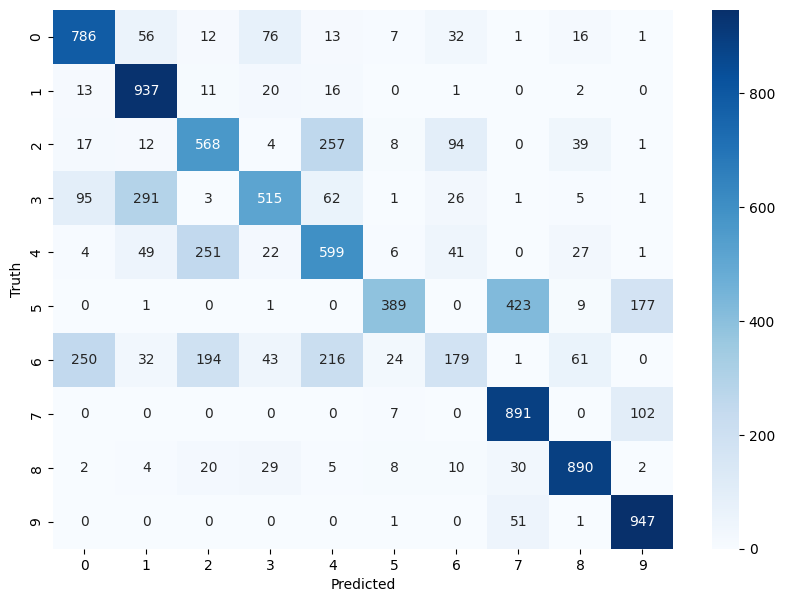

Training model with threshold: 0.7


Training Epoch 1:   2%|▏         | 2/100 [00:00<00:05, 18.92it/s]

Train Epoch: 0 [0/10000 (0%)]	Loss: 0.898347


Training Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 25.68it/s]



Epoch 1: Added 15254 items to the labeled dataset.

Correctly labeled: 14677, Incorrectly labeled: 577




Training Epoch 2:   3%|▎         | 7/253 [00:00<00:08, 30.42it/s]

Train Epoch: 1 [0/25254 (0%)]	Loss: 0.483565


Training Epoch 2:  42%|████▏     | 106/253 [00:03<00:04, 29.93it/s]

Train Epoch: 1 [10000/25254 (40%)]	Loss: 0.665821


Training Epoch 2:  81%|████████  | 204/253 [00:07<00:02, 20.15it/s]

Train Epoch: 1 [20000/25254 (79%)]	Loss: 0.430821


Training Epoch 2: 100%|██████████| 253/253 [00:09<00:00, 26.70it/s]



Epoch 2: Added 5038 items to the labeled dataset.

Correctly labeled: 4219, Incorrectly labeled: 819




Training Epoch 3:   1%|▏         | 4/303 [00:00<00:09, 30.77it/s]

Train Epoch: 2 [0/30292 (0%)]	Loss: 0.591833


Training Epoch 3:  35%|███▍      | 105/303 [00:03<00:06, 29.87it/s]

Train Epoch: 2 [10000/30292 (33%)]	Loss: 0.404973


Training Epoch 3:  68%|██████▊   | 206/303 [00:06<00:03, 29.32it/s]

Train Epoch: 2 [20000/30292 (66%)]	Loss: 0.318210


Training Epoch 3: 100%|██████████| 303/303 [00:11<00:00, 27.06it/s]


Train Epoch: 2 [30000/30292 (99%)]	Loss: 0.450571

Epoch 3: Added 1934 items to the labeled dataset.

Correctly labeled: 1802, Incorrectly labeled: 132




Training Epoch 4:   1%|          | 4/323 [00:00<00:16, 19.23it/s]

Train Epoch: 3 [0/32226 (0%)]	Loss: 0.463953


Training Epoch 4:  33%|███▎      | 105/323 [00:03<00:07, 29.76it/s]

Train Epoch: 3 [10000/32226 (31%)]	Loss: 0.510096


Training Epoch 4:  64%|██████▍   | 206/323 [00:07<00:04, 28.93it/s]

Train Epoch: 3 [20000/32226 (62%)]	Loss: 0.275772


Training Epoch 4:  94%|█████████▍| 303/323 [00:11<00:00, 21.31it/s]

Train Epoch: 3 [30000/32226 (93%)]	Loss: 0.357784


Training Epoch 4: 100%|██████████| 323/323 [00:12<00:00, 26.12it/s]



Epoch 4: Added 2374 items to the labeled dataset.

Correctly labeled: 2086, Incorrectly labeled: 288




Training Epoch 5:   1%|          | 3/346 [00:00<00:12, 26.79it/s]

Train Epoch: 4 [0/34600 (0%)]	Loss: 0.372889


Training Epoch 5:  31%|███       | 106/346 [00:04<00:10, 23.01it/s]

Train Epoch: 4 [10000/34600 (29%)]	Loss: 0.377140


Training Epoch 5:  60%|█████▉    | 207/346 [00:07<00:04, 30.73it/s]

Train Epoch: 4 [20000/34600 (58%)]	Loss: 0.428860


Training Epoch 5:  88%|████████▊ | 305/346 [00:11<00:01, 29.89it/s]

Train Epoch: 4 [30000/34600 (87%)]	Loss: 0.283624


Training Epoch 5: 100%|██████████| 346/346 [00:12<00:00, 27.71it/s]



Epoch 5: Added 1409 items to the labeled dataset.

Correctly labeled: 1193, Incorrectly labeled: 216






Validation: 100%|██████████| 100/100 [00:01<00:00, 50.32it/s]



Final Metrics:
Accuracy: 73.37%
Recall: 73.37%
F1-score: 72.29%


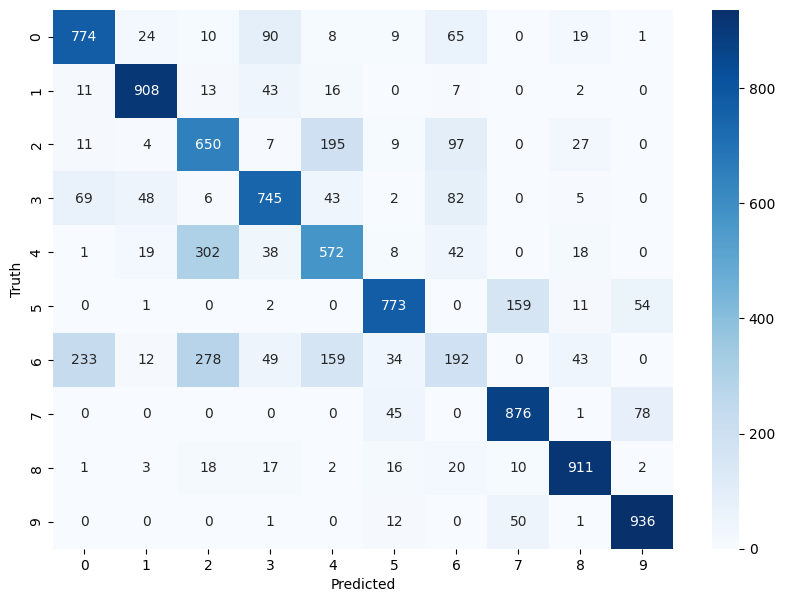

Training model with threshold: 0.8


Training Epoch 1:   3%|▎         | 3/100 [00:00<00:03, 27.30it/s]

Train Epoch: 0 [0/10000 (0%)]	Loss: 0.712163


Training Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 26.29it/s]



Epoch 1: Added 20968 items to the labeled dataset.

Correctly labeled: 20124, Incorrectly labeled: 844




Training Epoch 2:   2%|▏         | 7/310 [00:00<00:10, 29.41it/s]

Train Epoch: 1 [0/30968 (0%)]	Loss: 0.410096


Training Epoch 2:  34%|███▍      | 105/310 [00:03<00:07, 29.25it/s]

Train Epoch: 1 [10000/30968 (32%)]	Loss: 0.231658


Training Epoch 2:  65%|██████▌   | 203/310 [00:07<00:05, 19.80it/s]

Train Epoch: 1 [20000/30968 (65%)]	Loss: 0.472692


Training Epoch 2:  98%|█████████▊| 304/310 [00:11<00:00, 28.64it/s]

Train Epoch: 1 [30000/30968 (97%)]	Loss: 0.401735


Training Epoch 2: 100%|██████████| 310/310 [00:11<00:00, 26.87it/s]



Epoch 2: Added 1336 items to the labeled dataset.

Correctly labeled: 1196, Incorrectly labeled: 140




Training Epoch 3:   2%|▏         | 7/324 [00:00<00:10, 29.98it/s]

Train Epoch: 2 [0/32304 (0%)]	Loss: 0.408181


Training Epoch 3:  32%|███▏      | 104/324 [00:03<00:07, 30.08it/s]

Train Epoch: 2 [10000/32304 (31%)]	Loss: 0.319221


Training Epoch 3:  63%|██████▎   | 204/324 [00:06<00:04, 29.52it/s]

Train Epoch: 2 [20000/32304 (62%)]	Loss: 0.379475


Training Epoch 3:  94%|█████████▍| 304/324 [00:11<00:01, 18.74it/s]

Train Epoch: 2 [30000/32304 (93%)]	Loss: 0.498323


Training Epoch 3: 100%|██████████| 324/324 [00:11<00:00, 27.16it/s]



Epoch 3: Added 564 items to the labeled dataset.

Correctly labeled: 523, Incorrectly labeled: 41




Training Epoch 4:   2%|▏         | 7/329 [00:00<00:10, 29.81it/s]

Train Epoch: 3 [0/32868 (0%)]	Loss: 0.286869


Training Epoch 4:  32%|███▏      | 106/329 [00:04<00:07, 28.88it/s]

Train Epoch: 3 [10000/32868 (30%)]	Loss: 0.423224


Training Epoch 4:  62%|██████▏   | 204/329 [00:07<00:04, 29.22it/s]

Train Epoch: 3 [20000/32868 (61%)]	Loss: 0.405888


Training Epoch 4:  93%|█████████▎| 306/329 [00:11<00:00, 29.07it/s]

Train Epoch: 3 [30000/32868 (91%)]	Loss: 0.386463


Training Epoch 4: 100%|██████████| 329/329 [00:12<00:00, 27.10it/s]



Epoch 4: Added 1141 items to the labeled dataset.

Correctly labeled: 927, Incorrectly labeled: 214




Training Epoch 5:   1%|          | 4/341 [00:00<00:10, 30.65it/s]

Train Epoch: 4 [0/34009 (0%)]	Loss: 0.377766


Training Epoch 5:  31%|███       | 105/341 [00:03<00:08, 28.66it/s]

Train Epoch: 4 [10000/34009 (29%)]	Loss: 0.457575


Training Epoch 5:  61%|██████    | 207/341 [00:08<00:04, 28.48it/s]

Train Epoch: 4 [20000/34009 (59%)]	Loss: 0.598028


Training Epoch 5:  90%|████████▉ | 306/341 [00:11<00:01, 28.51it/s]

Train Epoch: 4 [30000/34009 (88%)]	Loss: 0.262584


Training Epoch 5: 100%|██████████| 341/341 [00:12<00:00, 26.77it/s]



Epoch 5: Added 609 items to the labeled dataset.

Correctly labeled: 560, Incorrectly labeled: 49






Validation: 100%|██████████| 100/100 [00:02<00:00, 49.61it/s]



Final Metrics:
Accuracy: 75.61%
Recall: 75.61%
F1-score: 75.18%


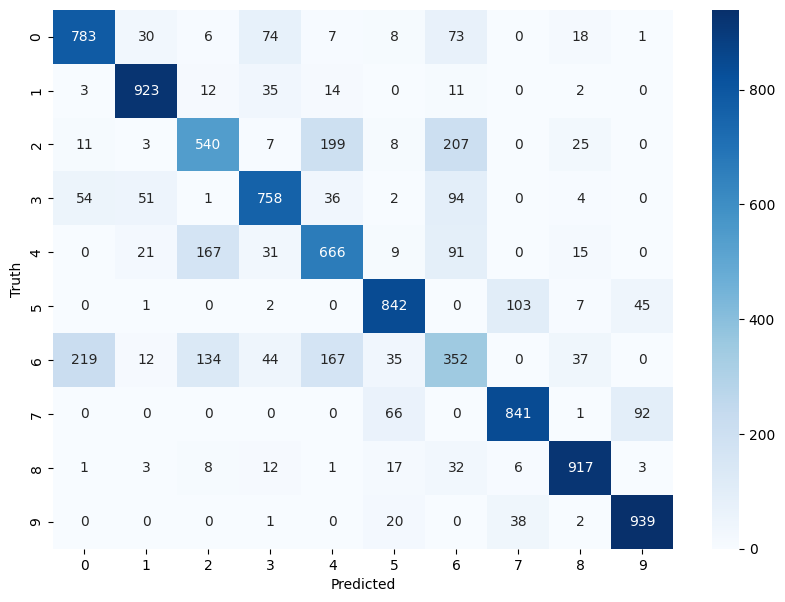

Training model with threshold: 0.9


Training Epoch 1:   3%|▎         | 3/100 [00:00<00:03, 27.32it/s]

Train Epoch: 0 [0/10000 (0%)]	Loss: 0.593454


Training Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 30.10it/s]



Epoch 1: Added 16713 items to the labeled dataset.

Correctly labeled: 16470, Incorrectly labeled: 243




Training Epoch 2:   2%|▏         | 5/268 [00:00<00:12, 20.39it/s]

Train Epoch: 1 [0/26713 (0%)]	Loss: 0.227891


Training Epoch 2:  40%|███▉      | 106/268 [00:03<00:05, 28.75it/s]

Train Epoch: 1 [10000/26713 (37%)]	Loss: 0.302063


Training Epoch 2:  77%|███████▋  | 207/268 [00:07<00:02, 29.84it/s]

Train Epoch: 1 [20000/26713 (75%)]	Loss: 0.304611


Training Epoch 2: 100%|██████████| 268/268 [00:09<00:00, 28.47it/s]



Epoch 2: Added 1242 items to the labeled dataset.

Correctly labeled: 1165, Incorrectly labeled: 77




Training Epoch 3:   2%|▏         | 6/280 [00:00<00:09, 29.44it/s]

Train Epoch: 2 [0/27955 (0%)]	Loss: 0.325571


Training Epoch 3:  37%|███▋      | 103/280 [00:04<00:09, 19.04it/s]

Train Epoch: 2 [10000/27955 (36%)]	Loss: 0.175404


Training Epoch 3:  73%|███████▎  | 204/280 [00:07<00:02, 29.68it/s]

Train Epoch: 2 [20000/27955 (71%)]	Loss: 0.290043


Training Epoch 3: 100%|██████████| 280/280 [00:10<00:00, 26.69it/s]



Epoch 3: Added 791 items to the labeled dataset.

Correctly labeled: 751, Incorrectly labeled: 40




Training Epoch 4:   2%|▏         | 7/288 [00:00<00:09, 30.53it/s]

Train Epoch: 3 [0/28746 (0%)]	Loss: 0.224823


Training Epoch 4:  36%|███▋      | 105/288 [00:03<00:06, 28.99it/s]

Train Epoch: 3 [10000/28746 (35%)]	Loss: 0.219324


Training Epoch 4:  70%|███████   | 203/288 [00:07<00:04, 19.51it/s]

Train Epoch: 3 [20000/28746 (69%)]	Loss: 0.411045


Training Epoch 4: 100%|██████████| 288/288 [00:10<00:00, 26.34it/s]



Epoch 4: Added 505 items to the labeled dataset.

Correctly labeled: 471, Incorrectly labeled: 34




Training Epoch 5:   2%|▏         | 6/293 [00:00<00:09, 29.02it/s]

Train Epoch: 4 [0/29251 (0%)]	Loss: 0.291017


Training Epoch 5:  36%|███▌      | 105/293 [00:03<00:06, 29.13it/s]

Train Epoch: 4 [10000/29251 (34%)]	Loss: 0.291870


Training Epoch 5:  70%|██████▉   | 205/293 [00:07<00:02, 29.50it/s]

Train Epoch: 4 [20000/29251 (68%)]	Loss: 0.462328


Training Epoch 5: 100%|██████████| 293/293 [00:10<00:00, 28.65it/s]



Epoch 5: Added 98 items to the labeled dataset.

Correctly labeled: 95, Incorrectly labeled: 3






Validation: 100%|██████████| 100/100 [00:02<00:00, 44.39it/s]



Final Metrics:
Accuracy: 76.60%
Recall: 76.60%
F1-score: 76.36%


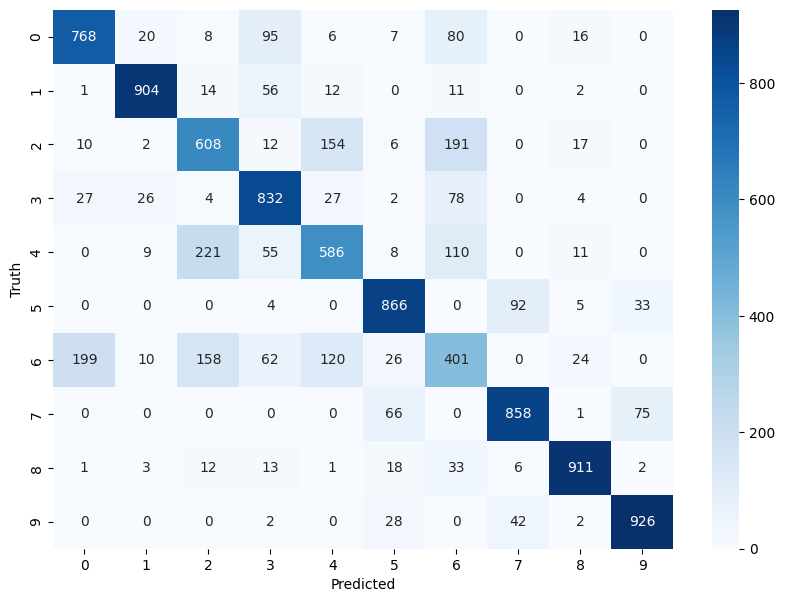

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
learning_rate = 1e-3
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

n_classes = 10  # there are 10 classes
n_channels = 16

criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

model = CNN(n_channels, n_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

epochs = 5

thresholds = [0.6, 0.7, 0.8, 0.9]

print(f"Number of parameters: {get_n_params(model)}\n")

for threshold in thresholds:

    print("Training model with threshold:",threshold)
    self_training(epochs, DL_dataset, DU_dataset, model, criterion, optimizer, threshold)
    print("\n")

    # Calculate metrics
    final_val_loss, all_preds, all_labels = validate(criterion, model, val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    print(f'\nFinal Metrics:')
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    print(f'F1-score: {f1*100:.2f}%')

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

## **Analysis of self-training procedure and results:**
